In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

### Create dataframe

In [161]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [202]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]

In [203]:
df.head()

,A1BG,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS1,...,ZSWIM5,ZSWIM6,ZSWIM7,ZSWIM8,ZUP1,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3
human_759_WM,-0.065495,0.010434,0.041268,-0.054351,0.025707,-0.072019,-0.019207,0.051644,-0.040637,0.007453,...,0.036042,-0.025797,0.009901,0.071362,-0.083505,0.041762,-0.026634,-0.087689,-0.063893,-0.040384
human_j12_WM,-0.060239,0.019742,0.025153,-0.066483,-0.044543,0.001885,0.120468,0.044115,-0.005605,0.064853,...,0.008039,-0.011982,-0.000140,0.013841,-0.005179,-0.051615,-0.144635,-0.030077,-0.016105,0.055280
human_j3_WM,-0.095841,0.030377,-0.028083,-0.100378,-0.011412,0.121080,0.096006,-0.036493,-0.043526,-0.017252,...,-0.025040,0.025672,-0.022279,-0.063037,0.055279,-0.082378,-0.050937,-0.060124,-0.077665,0.020677
human_j4_WM,-0.091943,0.057763,-0.020194,-0.100982,-0.054054,0.040012,0.081541,-0.023853,0.081220,0.055494,...,-0.031159,-0.014967,-0.042334,0.014476,0.012403,-0.117408,-0.020468,-0.110733,-0.023327,0.078987
human_j6_WM,-0.078252,-0.015277,0.004524,-0.134850,0.010688,0.078731,-0.073053,0.049893,-0.014778,-0.074468,...,0.052648,-0.099636,0.030391,-0.021561,0.130150,-0.005066,0.020878,-0.112694,-0.059420,0.027191


In [204]:
df_cont = df.copy()
df_cont['condition'] = adata_pb_norm.obs.condition
df_cont['layer'] = adata_pb_norm.obs.layer
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
df_cont['intercept'] = 1

In [205]:
df_cont.columns = df_cont.columns.str.replace('-', '')

In [207]:
p_val_dict = dict()
for specie in ['human', 'chimp', 'macaque']:
    p_val_list = []
    for gene in tqdm(df_cont.columns[:-3]):
        formula = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
        subs_index = df_cont[df_cont.condition == specie].index
        model = ols(formula, data=df_cont, subset=subs_index).fit()
        p_val_list.append(model.f_pvalue)
    p_val_dict[specie] = p_val_list

  0%|          | 0/9208 [00:00<?, ?it/s]

D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid


  0%|          | 0/9208 [00:00<?, ?it/s]

D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-package

  0%|          | 0/9208 [00:00<?, ?it/s]

D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-package

In [213]:
results = pd.DataFrame(p_val_dict, index=df.columns)
results.head()

,human,chimp,macaque
A1BG,3.470042e-01,0.116883,0.566609
AAAS,5.520550e-01,0.898117,0.464406
AACS,1.205666e-03,0.014287,0.318736
AADAT,6.003434e-07,0.223451,0.017868
AAGAB,7.315753e-01,0.661344,0.024143


In [244]:
from itertools import permutations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
permut = list(permutations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(not_const_genes.str.replace('-', '')):
        subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        df_cont_sub = df_cont.loc[subs_index].copy()
        df_cont_sub.condition = df_cont_sub.condition.astype(str)
        
        formula1 = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
        model1 = ols(formula, data=df_cont_sub).fit()
        
        formula2 = f'{gene} ~ (layer + layer ^ 2 + layer ^ 3) * condition'
        model2 = ols(formula2, data=df_cont_sub).fit()

        res_list.append(model2.compare_f_test(model1))
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value', 'df'], index=not_const_genes)

  0%|          | 0/3411 [00:00<?, ?it/s]

  0%|          | 0/3411 [00:00<?, ?it/s]

  0%|          | 0/1786 [00:00<?, ?it/s]

  0%|          | 0/1786 [00:00<?, ?it/s]

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/2463 [00:00<?, ?it/s]

In [247]:
res_df = res_dict['human-chimp']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
ACADSB,9.203278,1.009170e-05,4.0
ACP2,15.102067,2.658578e-08,4.0
ACVR2B,5.262293,1.208149e-03,4.0
ADRB1,8.332296,2.726132e-05,4.0
AGPS,6.659328,2.031256e-04,4.0
...,...,...,...
ZNF584,8.050107,3.789672e-05,4.0
ZNF696,3.434350,1.436843e-02,4.0
ZNF708,4.707737,2.519210e-03,4.0
ZSCAN26,21.694479,1.205125e-10,4.0


In [250]:
res_df = res_dict['human-macaque']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AADAT,11.797851,5.467371e-07,4.0
ABT1,2.834464,3.291647e-02,4.0
ACADSB,2.806383,3.425278e-02,4.0
ACAP1,30.231716,2.583753e-13,4.0
ACVR2B,24.755808,9.391408e-12,4.0
...,...,...,...
ZNF746,27.557931,1.409289e-12,4.0
ZNF771,3.822281,8.213229e-03,4.0
ZNF84,9.541596,6.223484e-06,4.0
ZSCAN9,21.654566,9.017767e-11,4.0


In [155]:
gene = 'SST'
formula = f'{gene} ~ C(intercept)'
subs_index = df[df.condition == 'human'].index
model0 = ols(formula, data=df_cont, subset=subs_index).fit()

In [156]:
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SST   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                nan
Time:                        22:32:55   Log-Likelihood:                -7.1910
No. Observations:                  35   AIC:                             16.38
Df Residuals:                      34   BIC:                             17.94
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.705e-08      0.051   1.12e-06      1.000      -0.104       0.104
==============================================================================
Omnibus:                        2.851   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.505
Skew:                           0.640   Prob(JB):                        0.286
Kurtosis:                       2.714   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
gene = 'SST'
formula = f'{gene} ~ layer'
subs_index = df_cont[df_cont.condition == 'human'].index
model = ols(formula, data=df_cont, subset=subs_index).fit()

In [170]:
model.f_pvalue

0.04935424319597585

In [182]:
df_cont.columns = df_cont.columns.str.replace('.', '')

In [188]:
p_val_list = []
for gene in tqdm(df_cont.columns[:-3]):
    formula = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
    subs_index = df_cont[df_cont.condition == 'human'].index
    model = ols(formula, data=df_cont, subset=subs_index).fit()
    p_val_list.append(model.f_pvalue)

  0%|          | 0/9208 [00:00<?, ?it/s]

D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
D:\Projects\spatialMPFC\venv\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid


In [189]:
pval_ser = pd.Series(p_val_list, index=df_cont.columns[:-3])
pval_ser[pval_ser > 0.05]

A1BG      0.347004
AAAS      0.552055
AAGAB     0.731575
AAMDC     0.217338
AAMP      0.762617
            ...   
ZSWIM7    0.068975
ZSWIM8    0.267062
ZUP1      0.196775
ZWILCH    0.062732
ZZZ3      0.329154
Length: 5793, dtype: float64

In [191]:
model.compare_f_test(model0)

(1217.8182043038387, 3.115342411705299e-32, 3.0)

In [192]:
gene = 'SST'
formula = f'{gene} ~ layer'
subs_index = df_cont[df_cont.condition == 'human'].index
model1 = ols(formula, data=df_cont, subset=subs_index).fit()

In [194]:
gene = 'CCK'
formula = f'{gene} ~ layer'
subs_index = df_cont[df_cont.condition == 'human'].index
model2 = ols(formula, data=df_cont, subset=subs_index).fit()

In [197]:
model2.f_test(model1.params)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=50.640950179860326, p=3.768421472488644e-08, df_denom=33, df_num=1>

In [196]:
model1.f_test(model2.params)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=3.4091927801886013, p=0.07381966629107715, df_denom=33, df_num=1>

<Axes: xlabel='layer'>

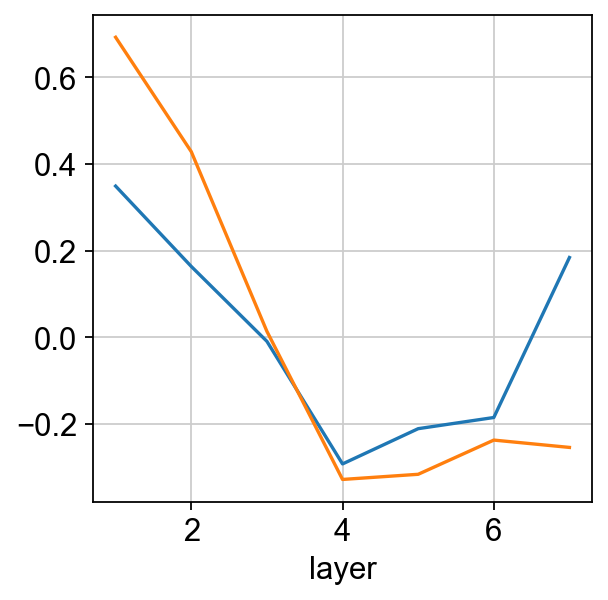

In [198]:
df_cont.loc[subs_index].groupby('layer')['SST'].mean().plot()
df_cont.loc[subs_index].groupby('layer')['CCK'].mean().plot()